<a href="https://colab.research.google.com/github/stefisha/StefanVelickovic_Omega_DS_InvestmentRounds/blob/main/Investment_rounds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Task Overview

The goal of this task is to create a classification model to predict the type of funding round a company is receiving (e.g., angel, seed, a, b, c) based on the provided dataset (`python_task_data.csv`). The dataset includes features like the number of employees, the amount of funding, and geographic information.

The steps we'll follow to build the model are:

1. **Exploratory Data Analysis (EDA)**: Analyze the dataset to understand the distribution of data, handle missing values, and gain insights into feature relationships.
2. **Feature Engineering**: Convert categorical features into numerical ones, scale the numeric features, and prepare the dataset for model training.
3. **Model Selection**: Try different machine learning models such as Random Forest, XGBoost, Logistic Regression, and others to find the best performing model.
4. **Model Evaluation**: Use evaluation metrics such as accuracy, precision, recall, and F1-score to assess model performance.
5. **Final Model**: Select and fine-tune the best model for deployment, ensuring it generalizes well to new data.

The final output of the task will be a trained machine learning model that can accurately predict the type of funding round based on the features from the datase, which will be turned into an API using Flask and put into a docker container.


In [12]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from scipy.stats import randint, uniform
from lightgbm import LGBMClassifier
from google.colab import drive
import joblib

In [13]:
# Mount Google Drive
drive.mount('/content/drive')

# Loading the dataset from Google Drive
file_path = '/content/drive/MyDrive/Data Science Task - VegaIT/python_task_data.csv'
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# Checking if properly loaded by desplaying first 5 rows
df.head()

,permalink,company,numEmps,category,city,state,fundedDate,raisedAmt,raisedCurrency,round
0,lifelock,LifeLock,NaN,web,Tempe,AZ,1-May-07,6850000,USD,b
1,lifelock,LifeLock,NaN,web,Tempe,AZ,1-Oct-06,6000000,USD,a
2,lifelock,LifeLock,NaN,web,Tempe,AZ,1-Jan-08,25000000,USD,c
3,mycityfaces,MyCityFaces,7.0,web,Scottsdale,AZ,1-Jan-08,50000,USD,seed
4,flypaper,Flypaper,NaN,web,Phoenix,AZ,1-Feb-08,3000000,USD,a


# Initial Data Exploration
#### We explore the dataset to understand its structure and identify any potential issues (e.g., missing values, outliers).

In [15]:
# Display basic information about the dataset
print("Basic Information:")
df.info()

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   permalink       1460 non-null   object 
 1   company         1460 non-null   object 
 2   numEmps         567 non-null    float64
 3   category        1436 non-null   object 
 4   city            1442 non-null   object 
 5   state           1460 non-null   object 
 6   fundedDate      1460 non-null   object 
 7   raisedAmt       1460 non-null   int64  
 8   raisedCurrency  1460 non-null   object 
 9   round           1460 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 114.2+ KB


In [16]:
# Check for missing values
print("Missing values per column:")
df.isnull().sum()

Missing values per column:


,0
permalink,0
company,0
numEmps,893
category,24
city,18
state,0
fundedDate,0
raisedAmt,0
raisedCurrency,0
round,0


In [17]:
# Check the distribution of the target variable (e.g., 'round')
print("Distribution of target variable:")
print(df['round'].value_counts())

Distribution of target variable:
round
a               582
b               371
c               141
angel           135
seed            128
d                47
unattributed     28
debt_round       17
e                11
Name: count, dtype: int64


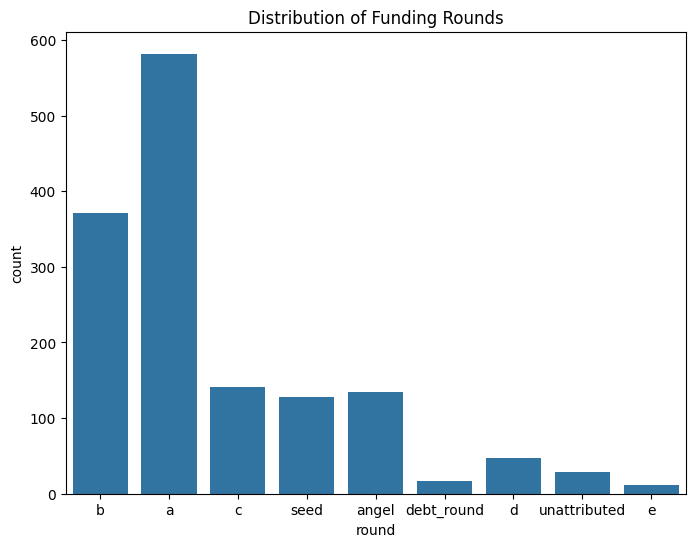

In [18]:
# Plotting the distribution of target variable (round)
plt.figure(figsize=(8, 6))
sns.countplot(x='round', data=df)
plt.title('Distribution of Funding Rounds')
plt.show()

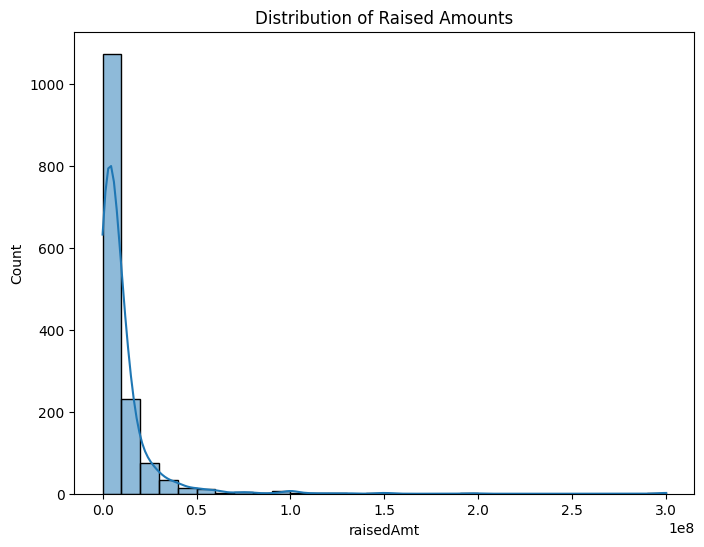

In [19]:
# Distribution of 'raisedAmt' (a key financial feature)
plt.figure(figsize=(8, 6))
sns.histplot(df['raisedAmt'].dropna(), bins=30, kde=True)
plt.title('Distribution of Raised Amounts')
plt.show()

# Data Cleaning, Preprocessing, and Feature Engineering

**Explanation:**
- Data Cleaning involves filling missing values, dropping irrelevant columns, and converting categorical features into dummy variables.
- We extract useful features such as `fundedYear` from the date and convert categorical variables into numerical format for the model.
- This step prepares the data to be fed into machine learning models.

**Why:**
- We clean the data by filling missing values and handling categorical variables.
- Properly processed data ensures the model can be trained effectively without bias or errors.


In [20]:
# Fill missing values for numEmps using the median
df['numEmps'] = df['numEmps'].fillna(df['numEmps'].median())

# Convert fundedDate to datetime format
if 'fundedDate' in df.columns:
    df['fundedDate'] = pd.to_datetime(df['fundedDate'], errors='coerce')

    # Create a new column for fundedYear from the fundedDate
    df['fundedYear'] = df['fundedDate'].dt.year

    # Drop rows with missing fundedDate values
    df = df.dropna(subset=['fundedDate'])

    # Drop unwanted columns
    df = df.drop(columns=['permalink', 'company', 'fundedDate'])

# Convert categorical columns into dummy variables
columns_to_dummy = ['category', 'city', 'state', 'raisedCurrency']
available_columns = [col for col in columns_to_dummy if col in df.columns]

# Apply get_dummies only to available columns
df = pd.get_dummies(df, columns=available_columns, drop_first=True)

Why we dropped these features:
- **`permalink` and `company`**: These columns act as identifiers and are not helpful for predicting the target variable.
- **`fundedDate`**: We already extracted the important information (the year), so the full date is no longer needed.

In [21]:
# Defining the features (X) and target variable (y)
X = df.drop(columns=['round'])
y = df['round']

In [22]:
# Encode the target variable (for XGBoost)
le = LabelEncoder()
y = le.fit_transform(y)

In [23]:
# Check the processed dataframe
print(df.columns)
df.head()

Index(['numEmps', 'raisedAmt', 'round', 'fundedYear', 'category_cleantech',
       'category_consulting', 'category_hardware', 'category_mobile',
       'category_other', 'category_software',
       ...
       'state_OR', 'state_PA', 'state_RI', 'state_TN', 'state_TX', 'state_UT',
       'state_VA', 'state_WA', 'raisedCurrency_EUR', 'raisedCurrency_USD'],
      dtype='object', length=237)


,numEmps,raisedAmt,round,fundedYear,category_cleantech,category_consulting,category_hardware,category_mobile,category_other,category_software,...,state_OR,state_PA,state_RI,state_TN,state_TX,state_UT,state_VA,state_WA,raisedCurrency_EUR,raisedCurrency_USD
0,20.0,6850000,b,2007,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,20.0,6000000,a,2006,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,20.0,25000000,c,2008,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,7.0,50000,seed,2008,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,20.0,3000000,a,2008,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


# Base Model Creation: XGBoost

**Why XGBoost for the initial model?**
- It handles class imbalance well (though we'll enhance with SMOTE later).
- It's a boosting algorithm, meaning it corrects errors sequentially, making it highly accurate on structured data.
- XGBoost often outperforms Random Forest on tabular data without heavy tuning.

In [24]:
# Split the data into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Train a basic XGBoost model
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [26]:
# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

In [27]:
# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"Random Forest Model Accuracy: {accuracy_xgb * 100:.2f}%")
print("\nClassification Report for Random Forest:")
print(classification_report(y_test, y_pred_xgb, target_names=le.classes_))

Random Forest Model Accuracy: 48.63%

Classification Report for Random Forest:
              precision    recall  f1-score   support

           a       0.59      0.69      0.63       122
       angel       0.50      0.30      0.37        27
           b       0.39      0.46      0.42        74
           c       0.24      0.19      0.21        27
           d       0.00      0.00      0.00        10
  debt_round       0.00      0.00      0.00         4
           e       0.00      0.00      0.00         1
        seed       0.61      0.46      0.52        24
unattributed       0.00      0.00      0.00         3

    accuracy                           0.49       292
   macro avg       0.26      0.23      0.24       292
weighted avg       0.46      0.49      0.47       292



What we can do to improve the model:
### 1. Handle Class Imbalance
- **Problem**: The dataset might have imbalanced classes where some funding rounds (e.g., 'angel', 'seed') have fewer samples compared to others (e.g., 'a', 'b').
- **Solution**: Apply **SMOTE (Synthetic Minority Over-sampling Technique)** to generate synthetic samples for underrepresented classes and balance the dataset.

### 2. Hyperparameter Tuning
- **Problem**: The default hyperparameters may not be optimal for the XGBoost model, limiting its performance.
- **Solution**: Use **GridSearchCV** to tune hyperparameters and find the best set of parameters for the model, improving accuracy, precision, recall, and F1-score.

### 3. Cross-Validation
- **Problem**: The performance on a single test set might not generalize well to unseen data.
- **Solution**: Use **cross-validation** (such as 5-fold) to evaluate the model on multiple subsets of the data and get a more robust performance estimate.

### 4. Feature Scaling
- **Problem**: Features with large variations in value (like `raisedAmt`) can negatively impact the model's performance.
- **Solution**: Normalize the feature values using **MinMaxScaler** or **StandardScaler**, especially for algorithms sensitive to feature magnitude (like XGBoost).

### 5. Feature Importance and Selection
- **Problem**: Some features might not contribute much to the prediction, while others might have more predictive power, so we can try using only these features.
- **Solution**: Analyze **feature importance** after training and consider selecting the most important features or removing less important ones to improve model efficiency.

# Advanced Model: XGBoost with Hyperparameter Tuning

Let's implement all the improvements discussed.


In [28]:
# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Scale features (more important for models like SVM or KNN)
scaler = MinMaxScaler()
X_resampled = scaler.fit_transform(X_resampled)

# Encode target variable
le = LabelEncoder()
y_resampled = le.fit_transform(y_resampled)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

**Why SMOTE?**
- When the dataset has imbalanced classes (i.e., some rounds have fewer samples), SMOTE generates synthetic examples to balance the data.
- This ensures the model doesn't overfit to the majority class and helps achieve better generalization.

In [29]:
# Train an XGBoost model
xgb_model = XGBClassifier(random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'reg_alpha': [0.1, 1, 10],  # L1 regularization
    'reg_lambda': [0.1, 1, 10]  # L2 regularization
}

In [ ]:
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


In [ ]:
# Get the best model from the grid search
improved_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

In [ ]:
# Make predictions with the best XGBoost model
y_pred_xgb = improved_model.predict(X_test)

In [ ]:
# Evaluate the XGBoost model: cross-validation accuracy
cv_scores = cross_val_score(improved_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores.mean() * 100:.2f}%")

# Convert target names to strings
target_names = [str(cls) for cls in le.classes_]

# Print classification report
print("\nClassification Report for XGBoost:")
print(classification_report(y_test, y_pred_xgb, target_names=target_names))

### Model Performance Summary

The **XGBoost** model's accuracy has improved to **84.92%** after tuning. Notable results include:

- **High performance** for categories like **debt_round**, **e**, and **seed**, with precision and recall above 90%.
- **Moderate performance** for categories like **round a** and **round b**, showing room for improvement, meaning additional feature engineering or balancing techniques might be explored to improve these predictions.

While the model performs well, further improvements could be explored through:
- **Additional hyperparameter tuning**.
- **Feature selection**
- **Balancing techniques** to further improve predictions for underperforming categories.

The current model will now be saved, but there's still potential to fine-tune for even better performance.

In [ ]:
# Save the best XGBoost model
joblib.dump(improved_model, 'xgboost_model.pkl')

# Feature Importance Analysis and Feature Selection

**Explanation:**
- Once the model is trained, we analyze the importance of each feature. We limit to the top 20 features and plot their importances.
- This helps us focus on the most informative features.

**Why:**
- Selecting only the top features can reduce noise and improve model efficiency, leading to better generalization.


In [ ]:
# Get feature importance from the best XGBoost model
xgb_importances = improved_model.feature_importances_
sorted_idx = np.argsort(xgb_importances)[::-1]  # Sort in descending order
# Select the top features
top_features = df.columns[sorted_idx]

In [ ]:
# Limit to top 20 features
N = 20
sorted_idx = sorted_idx[:N]

In [ ]:
# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(df.columns[sorted_idx], xgb_importances[sorted_idx], color='blue')
plt.xlabel("XGBoost Feature Importance")
plt.title("Top 20 Feature Importances in XGBoost")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Filter the dataset to include only the top N features
X_train_top = X_train[:, sorted_idx]
X_test_top = X_test[:, sorted_idx]

In [ ]:
# Train a new XGBoost model with top N features
best_features = XGBClassifier(n_estimators=200, max_depth=10, learning_rate=0.1, random_state=42)
best_features.fit(X_train_top, y_train)

# Make predictions and evaluate the model
y_pred_top = best_features.predict(X_test_top)

In [ ]:
# Evaluate the new XGBoost model
cv_scores = cross_val_score(best_features, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores.mean() * 100:.2f}%")
target_names = [str(cls) for cls in le.classes_]
print("\nClassification Report for XGBoost:")
print(classification_report(y_test, y_pred_xgb, target_names=target_names))

It seems we did not get better performance using the top features, in fact slightly worse.

# Train and Evaluate Other Models with Tuning and Voting Classifier

**Explanation:**
- We evaluate multiple models (Random Forest, Logistic Regression, LightGBM, etc.) using hyperparameter tuning.
- A voting classifier combines the strengths of multiple models for more robust predictions.

**Why:**
- Trying different models and combining them ensures that the final predictions are based on the strengths of each model, leading to better generalization and performance.

In [ ]:
# Helper function to evaluate and print metrics
def calculate_and_print_metrics(y_true, y_pred):
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='weighted'),
        'recall': recall_score(y_true, y_pred, average='weighted'),
        'f1_score': f1_score(y_true, y_pred, average='weighted')
    }
    print(f"Accuracy: {metrics['accuracy']:.2f}")
    print(f"Precision: {metrics['precision']:.2f}")
    print(f"Recall: {metrics['recall']:.2f}")
    print(f"F1 Score: {metrics['f1_score']:.2f}")

In [ ]:
# Hyperparameter grids for each model
param_grids = {
    'Random Forest': {
        'n_estimators': randint(100, 500),
        'max_depth': randint(3, 20),
        'min_samples_split': randint(2, 20)
    },
    'LightGBM': {
        'n_estimators': randint(100, 500),
        'max_depth': randint(3, 20),
        'learning_rate': uniform(0.01, 0.3),
        'num_leaves': randint(20, 50),
        'subsample': uniform(0.5, 1.0)
    },
    'Logistic Regression': {
        'C': uniform(0.1, 10),
        'solver': ['liblinear', 'lbfgs'],
        'max_iter': [100, 200, 300]
    },
    'K-Nearest Neighbors': {
        'n_neighbors': randint(1, 20),
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    },
    'Decision Tree': {
        'max_depth': randint(3, 20),
        'min_samples_split': randint(2, 20)
    }
}

Comparing with Other Models

**Why try other models?**
- While XGBoost is powerful, it’s good practice to compare it with simpler models like Random Forest, Logistic Regression, etc., to see if any model can perform similarly with less complexity or provide more interpretability.

In [ ]:
# Train and evaluate individual models with hyperparameter tuning
def train_and_evaluate_models_with_tuning(X_train, X_test, y_train, y_test):
    models = {
        'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
        'LightGBM': LGBMClassifier(random_state=42),
        'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42),
        'K-Nearest Neighbors': KNeighborsClassifier(),
        'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42)
    }

    results = []
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for model_name, model in models.items():
        print(f"\nTraining and Tuning {model_name}...")

        # Perform hyperparameter tuning using RandomizedSearchCV with 20 iterations
        random_search = RandomizedSearchCV(model, param_grids[model_name], n_iter=20, cv=cv, random_state=42, n_jobs=-1)
        random_search.fit(X_train, y_train)

        best_model = random_search.best_estimator_
        print(f"Best Parameters for {model_name}: {random_search.best_params_}")

        # Train the best model and evaluate
        best_model.fit(X_train, y_train)
        y_pred = best_model.predict(X_test)

        # # Print classification report
        # print(f"\nClassification Report for {model_name}:\n")
        # print(classification_report(y_test, y_pred, target_names=le.classes_))

        # Store model results
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        results.append({
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })

    return results

In [ ]:
# Function to visualize the results
def plot_metrics(results):
    # Extract model names and their corresponding metrics
    models = [result['Model'] for result in results]
    accuracy = [result['Accuracy'] for result in results]
    precision = [result['Precision'] for result in results]
    recall = [result['Recall'] for result in results]
    f1_score = [result['F1 Score'] for result in results]

    # Create bar chart for each metric
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    metric_values = [accuracy, precision, recall, f1_score]

    # Plot each metric in a separate subplot
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    for i, ax in enumerate(axs.flat):
        ax.barh(models, metric_values[i], color='b')
        ax.set_title(metrics[i])
        ax.set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

In [ ]:
# Training and evaluating the models
results = train_and_evaluate_models_with_tuning(X_train, X_test, y_train, y_test)

In [ ]:
# Print model results
for result in results:
    print(result)

In [ ]:
# Plot metrics for the models
plot_metrics(results)

It seems that the only model that is getting close is LightGBM, also a gradient boosting alghotitm. It is getting `F1 Score: 0.857`. Let' remind ourselves what our XGBoost model gets.

In [ ]:
# Since we determined XGBoost is the best model, focus on XGBoost
best_model = XGBClassifier(n_estimators=200, max_depth=10, learning_rate=0.1, random_state=42)

In [ ]:
# Train the best XGBoost model on the final training set
best_model.fit(X_train, y_train)

In [ ]:
# Make predictions and evaluate
y_pred = best_model.predict(X_test)

In [ ]:
# Calculate and print final evaluation metrics for XGBoost
calculate_and_print_metrics(y_test, y_pred)

It seems our model is still the best, edging out the other model by 0.01 to get `F1 Score: 0.86`. Let's plot the confusion matrix for the best model and proceed to saving it.

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification report for precision, recall, and F1-score
print(classification_report(y_test, y_pred))

# Save the Best Model

**Final step:**
- After selecting and training the best model, we save it to be able to use it within the API.
- Additionally, we save the expected column names to ensure that new data will have the same structure as the training data.

In [ ]:
# Save the original DataFrame column names before scaling
original_columns = X.columns

# Save the original column names for later use
joblib.dump(original_columns, 'expected_columns.pkl')

# Save the best model
joblib.dump(best_model, 'model.pkl')